---
title: Exploratory Data Analysis
description: ...
---

### Imports

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scapy.all as scapy
from pathlib import Path

### Loading data

In [85]:
data = Path('../data/data-en-hi-de-fr.csv')
df = pd.read_csv(data)
df.head()

,labels,text,text_hi,text_de,text_fr
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...","Dakag बिंदु तक जाओ, पागल. केवल Bag Non महान विश्व cag में उपलब्ध है... वहाँ एक अधिक wack मिला...","Gehen Sie bis jurong Punkt, verrückt.. Verfügbar nur in buggis n great world la e buffet... Cine there got amore wat...","Allez jusqu'à Jurong point, fou.. Disponible seulement dans bugis n grand monde la e buffet... Cine il y a eu plus..."
1,ham,Ok lar... Joking wif u oni...,ओके लामर.... if if uue पर.,Ok Lar... joking wif u oni...,J'ai fait une blague sur le wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,Fktatatat 21 मई को प्राप्त करने के लिए मुफ्त प्रविष्टि में. पाठ FAO को 87121 में प्रविष्टि प्राप्त करने के लिए(stibook दर) TTVERVE है 0. 08375750818 के मूल्य लागू करता है,"Freier Eintritt in 2 a wkly comp zum Gewinn FA Cup Final tkts 21. Mai 2005. Text FA bis 87121, um Eingangsfrage zu erhalten(std txt rate)T&C's gelten 08452810075over18's",Entrée libre dans 2 a wkly comp pour gagner FA Cup final tkts 21 mai 2005. Texte FA à 87121 pour recevoir la question d'entrée(std txt rate)T&C's appliquer 08452810075over18's
3,ham,U dun say so early hor... U c already then say...,Uden इतना जल्दी कहते हैं... तो पहले से ही यूसी कहते हैं...,U dun sagen so früh... U c schon dann sagen...,U dun dit si tôt hor... U c déjà dire alors...
4,ham,"Nah I don't think he goes to usf, he lives around here though","नहीं, मुझे नहीं लगता कि वह हमारे लिए चला जाता है, वह यहाँ के आसपास रहता है हालांकि","Nein, ich glaube nicht, dass er zu unsf geht, er lebt hier in der Nähe.","Non, je ne pense pas qu'il va à usf, il vit dans le coin."


In [86]:
df.labels.value_counts()

labels
ham     4825
spam     747
Name: count, dtype: int64

In [87]:
#| label: table_data_head

df = df[['labels', 'text_fr']]
df['labels'] = df['labels'].map({'ham': 0, 'spam': 1})
df = df.rename(columns={'text_fr': 'text', 'labels': 'is_spam'})

df.head().style.set_properties(subset=['text'], **{'width': '1000px'}).hide(axis='index')

is_spam,text
0,"Allez jusqu'à Jurong point, fou.. Disponible seulement dans bugis n grand monde la e buffet... Cine il y a eu plus..."
0,J'ai fait une blague sur le wif u oni...
1,Entrée libre dans 2 a wkly comp pour gagner FA Cup final tkts 21 mai 2005. Texte FA à 87121 pour recevoir la question d'entrée(std txt rate)T&C's appliquer 08452810075over18's
0,U dun dit si tôt hor... U c déjà dire alors...
0,"Non, je ne pense pas qu'il va à usf, il vit dans le coin."


### Preprocessing

In [88]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

preprocessor = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf_transformer', TfidfTransformer()),
])

preprocessor_param = {
    'preprocessor__vectorizer__ngram_range': [(1, 2)],
    'preprocessor__vectorizer__max_df': [0.5],
    'preprocessor__vectorizer__min_df': [0.01],
    'preprocessor__tfidf_transformer__use_idf': [True],
}

### Model definition

In [89]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

models = [
    {
        'model_name' : 'Naive Bayes',
        'model_filepath' : Path('naive_bayes_model.pkl'),
        'model_instance' : MultinomialNB(),
        'model_param' : 
        {
            'model__alpha' : np.linspace(0.1, 1, 10)
        },
        'best_model' : None,
    },
    {
        'model_name' : 'Logistic Regression',
        'model_filepath' : Path('logistic_regression_model.pkl'),
        'model_instance' : LogisticRegression(max_iter=1000),
        'model_param' : 
        {
            'model__C' : np.linspace(0.1, 1, 10)
        },
        'best_model' : None,
    },
    {
        'model_name' : 'SVM',
        'model_filepath' : Path('svm_model.pkl'),
        'model_instance' : SVC(probability=True),
        'model_param' : 
        { 
            'model__C' : np.linspace(0.1, 1, 10) 
        },
        'best_model': None,
    }
]

### Model training

In [90]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['is_spam'], test_size=0.3, random_state=42)

for model_infos in models:
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model_infos['model_instance'])
    ])
    
    param_grid = {**preprocessor_param, **model_infos['model_param']}
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Save the best model and parameters
    model_infos['best_model'] = grid_search.best_estimator_

### Model evaluation

Model: Naive Bayes
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1448
           1       0.96      0.83      0.89       224

    accuracy                           0.97      1672
   macro avg       0.97      0.91      0.94      1672
weighted avg       0.97      0.97      0.97      1672



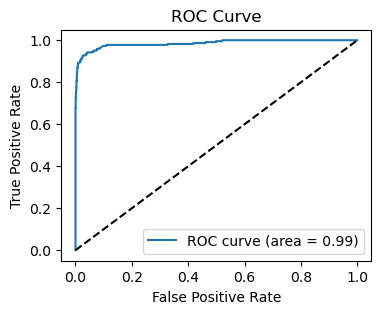

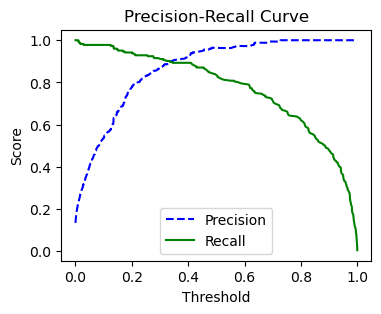

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1448
           1       0.98      0.80      0.88       224

    accuracy                           0.97      1672
   macro avg       0.97      0.90      0.93      1672
weighted avg       0.97      0.97      0.97      1672



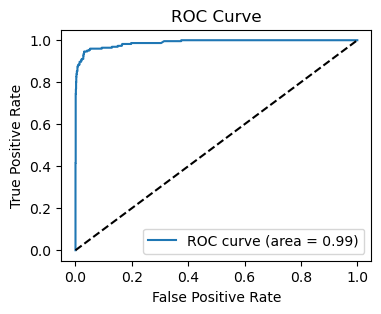

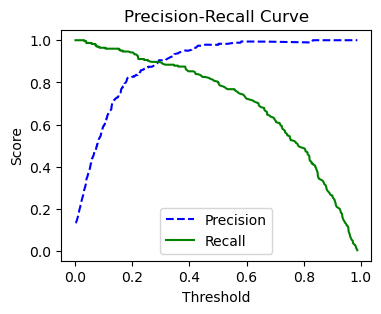

Model: SVM
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1448
           1       0.98      0.88      0.93       224

    accuracy                           0.98      1672
   macro avg       0.98      0.94      0.96      1672
weighted avg       0.98      0.98      0.98      1672



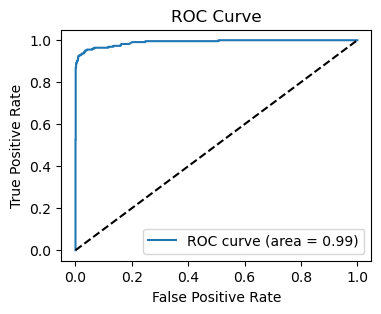

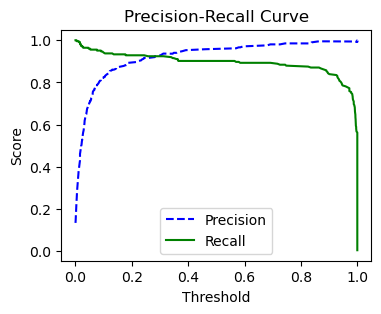

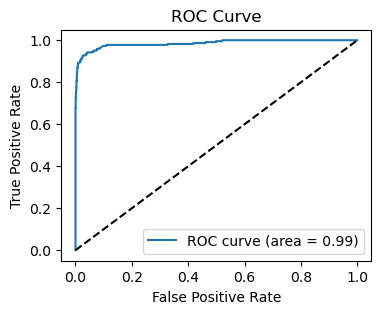

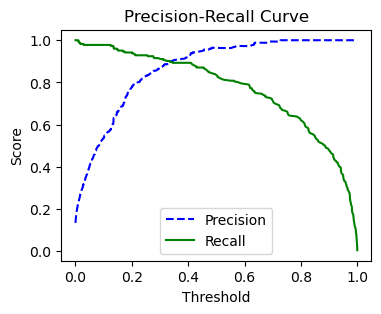

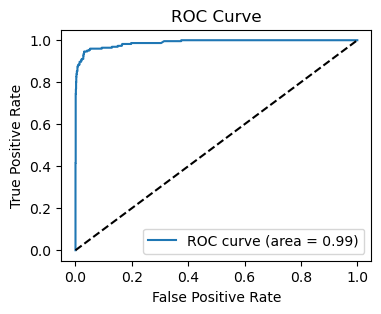

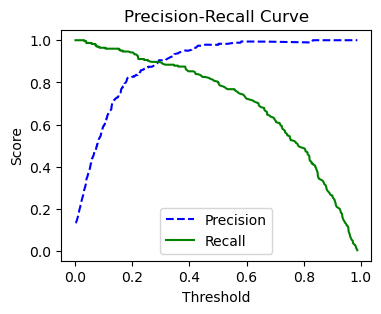

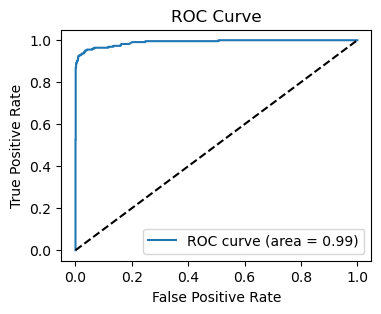

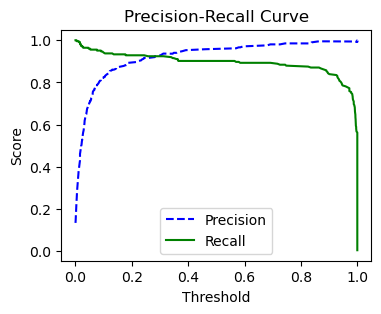

In [91]:
from sklearn.metrics import classification_report
from utils import get_roc_plot, get_precision_recall_plot

def evaluate_model(model_infos):
    best_model = model_infos['best_model']
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)
    
    print(f"Model: {model_infos['model_name']}")
    print(classification_report(y_test, y_pred))
    
    fig_precision_recall = get_roc_plot(y_test, y_pred_proba[:, 1])
    fig_precision_recall.savefig(Path("../assets/") / f"precision_recall_{model_infos['model_name']}.png")
    display(fig_precision_recall)
    
    fig_roc = get_precision_recall_plot(y_test, y_pred_proba[:, 1])
    fig_roc.savefig(Path("../assets/") / f"roc_{model_infos['model_name']}.png")
    display(fig_roc)

for model_infos in models:
    evaluate_model(model_infos)

### Refit and save model

In [92]:
import pickle

DATA_FOLDER = Path('../data')

# Refit and save model
for model_infos in models:
    best_model = model_infos['best_model']
    best_model.fit(df['text'], df['is_spam'])
    
    with open(DATA_FOLDER / model_infos['model_filepath'], 'wb') as f:
        pickle.dump(best_model, f)

### Load and perform model inference 

In [93]:
import ipywidgets as widgets
from IPython.display import display

# Load the saved model
model_filepath = Path('naive_bayes_model.pkl')  # Change this to the appropriate model file path
with open(DATA_FOLDER / model_filepath, 'rb') as f:
    loaded_model = pickle.load(f)

# Create an input widget
input_text = widgets.Textarea(
    value='',
    placeholder='Type something',
    description='Input:',
    disabled=False
)

# Create an output widget
output = widgets.Output()

# Define a function to perform inference
def on_text_submit(change):
    with output:
        output.clear_output()
        text = change['new']
        prediction = loaded_model.predict([text])
        prediction_proba = loaded_model.predict_proba([text])
        print(f"Prediction: {prediction[0]}")
        print(f"Prediction probabilities: {prediction_proba[0]}")

# Bind the function to the input widget
input_text.observe(on_text_submit, names='value')

# Display the widgets
display(input_text, output)

Textarea(value='', description='Input:', placeholder='Type something')

Output()